In [10]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [11]:
data_path = 'NCSU-DigIC-GraphData-2023-07-25/'

In [12]:
def instances_ini(i):
    with gzip.open(data_path + 'xbar/' + str(i) + '/xbar.json.gz','rb') as f:
        design = json.loads(f.read().decode('utf-8'))
        
    instances = pd.DataFrame(design['instances'])
    nets = pd.DataFrame(design['nets'])

    conn=np.load(data_path + 'xbar/' + str(i) + '/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)

    def buildBST(array,start=0,finish=-1):
        if finish<0:
            finish = len(array)
        mid = (start + finish) // 2
        if mid-start==1:
            ltl=start
        else:
            ltl=buildBST(array,start,mid)
        
        if finish-mid==1:
            gtl=mid
        else:
            gtl=buildBST(array,mid,finish)
            
        return((array[mid],ltl,gtl))

    congestion_data = np.load(data_path + 'xbar/' + str(i) + '/xbar_congestion.npz')
    xbst=buildBST(congestion_data['xBoundaryList'])
    ybst=buildBST(congestion_data['yBoundaryList'])
    demand = np.zeros(shape = [instances.shape[0],])
    capacity = np.zeros(shape = [instances.shape[0],])


    def getGRCIndex(x,y,xbst,ybst):
        while (type(xbst)==tuple):
            if x < xbst[0]:
                xbst=xbst[1]
            else:
                xbst=xbst[2]
                
        while (type(ybst)==tuple):
            if y < ybst[0]:
                ybst=ybst[1]
            else:
                ybst=ybst[2]
                
        return ybst, xbst

    for k in range(instances.shape[0]):
        # print(k)
        xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
        i,j=getGRCIndex(xloc,yloc,xbst,ybst)
        d = 0 
        c = 0
        for l in list(congestion_data['layerList']): 
            lyr=list(congestion_data['layerList']).index(l)
            d += congestion_data['demand'][lyr][i][j]
            c += congestion_data['capacity'][lyr][i][j]
        demand[k] = d
        capacity[k] = c
            
    instances['routing_demand'] = demand
    instances['routing_capacity'] = capacity
    instances['congestion'] = demand - capacity
    return instances, A

In [13]:
def cell_ini(i):
    with gzip.open(data_path + 'cells.json.gz','rb') as f:
        cells = json.loads(f.read().decode('utf-8'))

    cells = pd.DataFrame(cells)
    return cells

In [14]:
def norm_ohe(new_instances):
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()
    scaler = MinMaxScaler()
    new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']])
    return new_instances, orient

In [15]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.6):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

In [16]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [256]:
data = []
instance_lst = []
for i in range(0, 1):
    print(i)
    instances, A = instances_ini(i+1)
    instance_lst.append(instances)
    cells = cell_ini(i+1)
    new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
    new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height', 'orient']]
    new_instances, orient = norm_ohe(new_instances)
    y = new_instances[:,2]
    # remove congestion from new_instances
    node_features = np.delete(new_instances, 2, 1)
    node_features = np.concatenate((node_features, orient), axis=1)
    source_nodes, target_nodes = np.nonzero(A)
    edge_index = np.vstack((source_nodes, target_nodes))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    data.append(Data(x=x, edge_index=edge_index, y=y))


0
1
2
3
4
5
6
7
8
9
10
11


In [257]:
data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952]),
 Data(x=[6872, 8], edge_index=[2, 115420], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 126081], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 120929], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 121094], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 116592], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 122335], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 119388], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 119652], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 121838], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 115804], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 115553], y=[6529])]

In [276]:
train_data = data[:11]
# val_data = data[9:12]  
test_data = data[11:]

In [277]:
train_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952]),
 Data(x=[6872, 8], edge_index=[2, 115420], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 126081], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 120929], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 121094], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 116592], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 122335], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 119388], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 119652], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 121838], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 115804], y=[7814])]

In [278]:
test_data

[Data(x=[6529, 8], edge_index=[2, 115553], y=[6529])]

In [279]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=8, hidden_channels=8, out_channels=1, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

loss_values = []

# 1 for validation. 
#learning rate schu before
model.train()
for epoch in range(100):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)  
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/2360635926.py:16: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, graph_data.y)
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/2360635926.py:16: UserWarning: Using a target size (torch.Size([6872])) that is different to the input size (torch.Size([6872, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, graph_data.y)
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/2360635926.py:16: UserWarning: Using a target size (torch.Size([6913])) that is different to the input size (torch.Size([6913, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss

Epoch 1, Average Loss: 0.1692089560357007
Epoch 2, Average Loss: 0.13128961351784793
Epoch 3, Average Loss: 0.11265146461400119
Epoch 4, Average Loss: 0.10895469920201735
Epoch 5, Average Loss: 0.10654029995203018
Epoch 6, Average Loss: 0.10244572907686234
Epoch 7, Average Loss: 0.10142118619246916
Epoch 8, Average Loss: 0.09866111115975813
Epoch 9, Average Loss: 0.09892645545981148
Epoch 10, Average Loss: 0.09642788632349535
Epoch 11, Average Loss: 0.09689720584587617
Epoch 12, Average Loss: 0.09519034353169528
Epoch 13, Average Loss: 0.09405663812702353
Epoch 14, Average Loss: 0.09450227564031427
Epoch 15, Average Loss: 0.09349490228024396
Epoch 16, Average Loss: 0.09362641654231331
Epoch 17, Average Loss: 0.0929590721021999
Epoch 18, Average Loss: 0.09287581050937826
Epoch 19, Average Loss: 0.09441212971102107
Epoch 20, Average Loss: 0.09247981689193031
Epoch 21, Average Loss: 0.09083885834975676
Epoch 22, Average Loss: 0.09213722835887563
Epoch 23, Average Loss: 0.09149546853520653

In [280]:
def evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    # Optionally initialize other metrics here
    with torch.no_grad():
        for graph_data in data_list:
            print(graph_data)
            graph_data = graph_data.to(device)
            out = model(graph_data)
            predictions.append(out.cpu().detach().numpy())
            loss = F.mse_loss(out, graph_data.y)  # Adjust based on your specific loss function
            total_loss += loss.item()
            # Optionally compute additional metrics here
    
    avg_loss = total_loss / len(data_list)
    # Optionally compute averages for other metrics here
    return avg_loss, predictions  # And any other metrics

# Evaluate on validation and test sets
# val_loss = evaluate_model(model, val_data, device)
test_loss, predictions = evaluate_model(model, test_data, device)
# print(f'Validation Loss: {val_loss}')
print(f'Test Loss: {test_loss}')

Data(x=[6529, 8], edge_index=[2, 115553], y=[6529])
Test Loss: 0.05641406029462814


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/2660620629.py:12: UserWarning: Using a target size (torch.Size([6529])) that is different to the input size (torch.Size([6529, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, graph_data.y)  # Adjust based on your specific loss function


In [281]:
predictions[0].shape

(6529, 1)

In [283]:
data[11].y.cpu().detach().numpy().shape

(6529,)

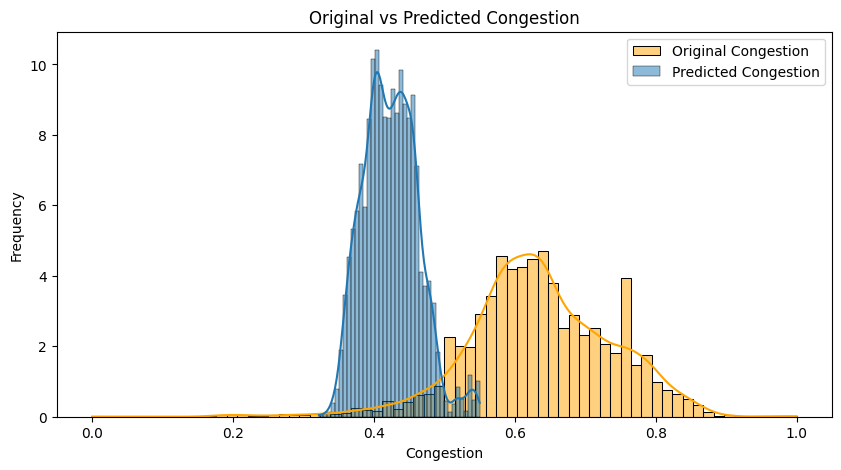

In [284]:
plt.figure(figsize=(10, 5))
sns.histplot(data[11].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

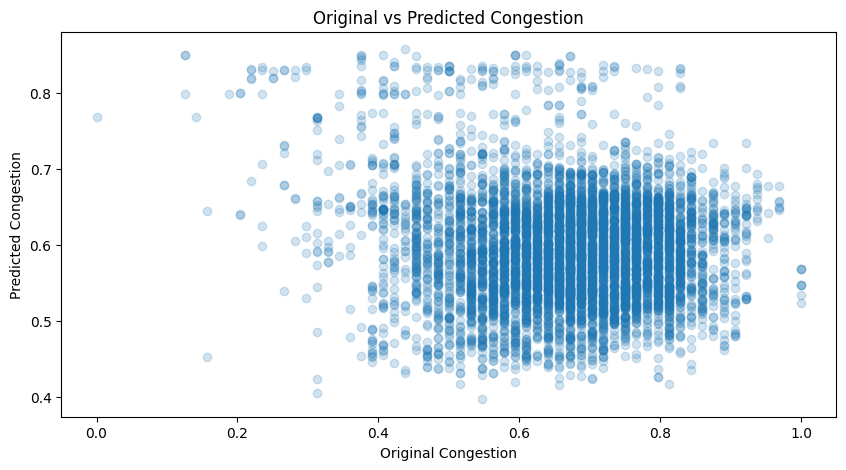

In [249]:
# plot a scatterplot of original congestion and predicted congestion
plt.figure(figsize=(10, 5))
plt.scatter(data[2].y.cpu().detach().numpy(), predictions[0], alpha=0.2)
plt.xlabel('Original Congestion')
plt.ylabel('Predicted Congestion')
plt.title('Original vs Predicted Congestion')
plt.show()

In [186]:
np.array(instance_lst[2][['congestion']].congestion)

array([-31., -23., -22., ..., -30., -33., -33.])

In [212]:
congestion_scaler = MinMaxScaler()
congestion_scaler.fit_transform(instance_lst[2][['congestion']])
#prediction = out.cpu().detach().numpy()
temp = congestion_scaler.inverse_transform(predictions[0])

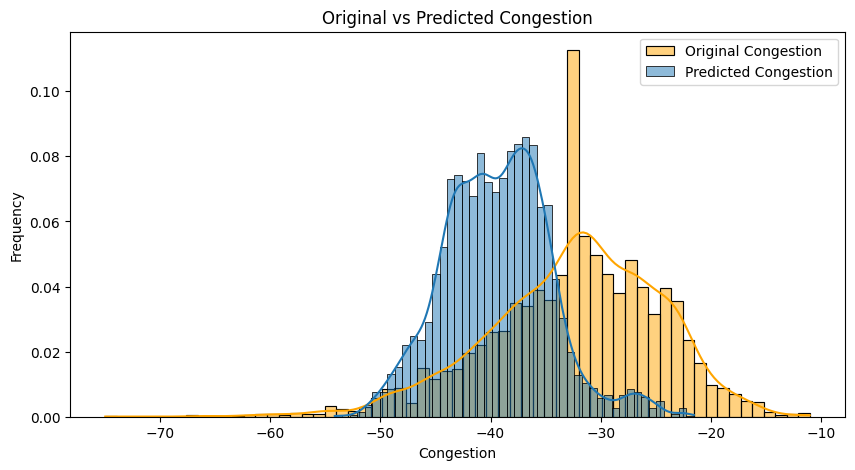

In [246]:
plt.figure(figsize=(10, 5))
sns.histplot(np.array(instance_lst[2][['congestion']].congestion), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(temp, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()